In [5]:
import pandas as pd 
import numpy as np
import joblib
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(".."))
from src.features import add_time_features

model=joblib.load("../data/processed/demand_model.pkl")
df = pd.read_csv("../data/processed/daily_demand.csv")
df["date"] = pd.to_datetime(df["date"])

C:\Users\Lovleen\AppData\Local\Temp\ipykernel_17560\186118703.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed/daily_demand.csv")


In [6]:
product_id=df["StockCode"].value_counts().idxmax()
product_df=df[df["StockCode"] == product_id].copy()

product_df.head()

,StockCode,date,Price,Quantity
230693,85123A,2009-12-01,2.55,192
230694,85123A,2009-12-01,2.95,65
230695,85123A,2009-12-02,2.55,654
230696,85123A,2009-12-02,2.95,93
230697,85123A,2009-12-03,2.55,192


Pricing decisions are made at product level, not globally.

In [7]:
product_df=add_time_features(product_df)

FEATURES=[
   "Price",
    "day",
    "month",
    "day_of_week",
    "is_weekend" 
]

In [8]:
current_price=product_df["Price"].median()

price_range=np.linspace(
    current_price*0.7,
    current_price*1.3,
    20
)

In [13]:
results=[]

base_row=product_df.iloc[-1].copy()

for price in price_range:
    row=base_row.copy()
    row["Price"]=price

    x=  pd.DataFrame([row[FEATURES]]) 
    predicted_demand=model.predict(x)[0]

    revenue=price*max(predicted_demand,0)

    results.append({
        "price":price,
        "predicted_demand":predicted_demand,
        "expected_revenue":revenue
    })

    results_df=pd.DataFrame(results)
    results_df

In [14]:
optimal_row=results_df.loc[results_df["expected_revenue"].idxmax()]
optimal_row

price                 3.089737
predicted_demand    308.240959
expected_revenue    952.383446
Name: 11, dtype: float64

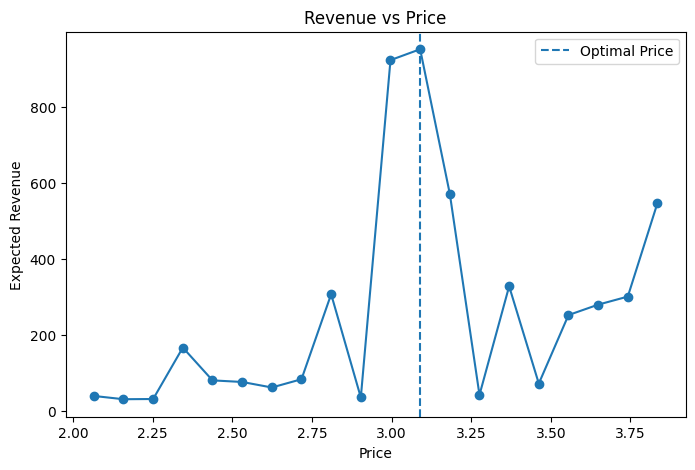

In [15]:
plt.figure(figsize=(8,5))
plt.plot(results_df["price"], results_df["expected_revenue"], marker="o")
plt.axvline(optimal_row["price"], linestyle="--", label="Optimal Price")
plt.xlabel("Price")
plt.ylabel("Expected Revenue")
plt.title("Revenue vs Price")
plt.legend()
plt.show()


### Pricing Optimization Insight

- Revenue follows a non-linear curve with price
- Increasing price initially increases revenue
- Beyond a threshold, demand drops faster than price increase
- Optimal price maximizes expected revenue
